## Mortgage Data
Annabella Stoll-Dansereau

 For a comprehensive report please see the pdf file. Much of this notebook isn't run because I ran it once and saved everything as csv files due to computational overhead. The more managable csv's created by the importing and matching are attached in the GitHub page for convience. 

### Data Source
This section involves reading mortgage data for selected counties in California, Arizona, and Nevada. The data, sourced from FHMA, covers the period from 2012 to 2019. Post-2019 data was excluded due to format changes which could affect consistency.

### Description of the Code
The code imports data from Sacramento, Fresno, Las Vegas, Reno, Tucson, and Phoenix. These cities were chosen for their similarities within Arizona. Using a cost of living comparison calculator (Forbes, 2023) a dictionary was created to map equivalent amounts to $98,500. The covariates include low income mortgage counts, income tract ratio (median income of a tract divided by the tract area's median income), and the percentage of minorities in each tract. Initially, there was an intention to include census data for additional covariates, such as home ownership rates, but computing limitations made this impractical within the project's timeframe.

The subsets of datasets are provided. Note that the following code functions correctly, but running it independently might require subsetting the data first and then merging it due to potential crashes during processing.

In [ ]:
import pandas as pd 

years = list(range(2012, 2020)) 

collapsed_df = None

# Thresholds dictionary
thresholds = {
    3: 98500, #Las Vegas county
    50: 107756, #Fresno county
    67: 119729, #Sacramento 
    31: 104637, #Reno
    19: 104336, #Tucson
    13: 103531, #Phoenix
    21: 103531 #Phoenix

}

# Function for counting low income mortgages
def count_low_income_mortgages(x, county_code):
    threshold = thresholds.get(county_code, 98500) # Default threshold
    return (x < threshold).sum()

for n, year in enumerate(years):
    df = pd.read_excel(rf"C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\State County {year}.xlsx")

    if n == 0:
        # Initial year, establish the collapsed_df with additional data
        collapsed_df = df.groupby(['Census Tract - 2010 Census']).apply(
            lambda group: pd.Series({
                'US Postal State Code': group['US Postal State Code'].iloc[0],
                'County - 2010 Census': group['County - 2010 Census'].iloc[0],
                '2010 Census Tract - Percent Minority': group['2010 Census Tract - Percent Minority'].iloc[0],
                'Tract Income Ratio': group['Tract Income Ratio'].iloc[0] * 100,
                f'Num Low Income Mortgages {year}': count_low_income_mortgages(group['Borrower(s) Annual Income'], group['County - 2010 Census'].iloc[0])
            })
        ).reset_index()
        
    else:
        # Subsequent years, only get the count data
        temp_df = df.groupby(['Census Tract - 2010 Census']).apply(
            lambda group: pd.Series({
                f'Num Low Income Mortgages {year}': count_low_income_mortgages(group['Borrower(s) Annual Income'], group['County - 2010 Census'].iloc[0])
            })
        ).reset_index()

        # Merge with the existing collapsed_df
        collapsed_df = collapsed_df.merge(temp_df, on='Census Tract - 2010 Census', how='left')
        collapsed_df = collapsed_df.fillna(0)

    print(f'done {year}')
# Save to CSV commmented out so its not run and overwrites my stuff by accident
#collapsed_df.to_csv(r'C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\20122019_collapsed_mortgage.csv', index=False)


#### Causuality Diagram, explaining the quesiton at hand

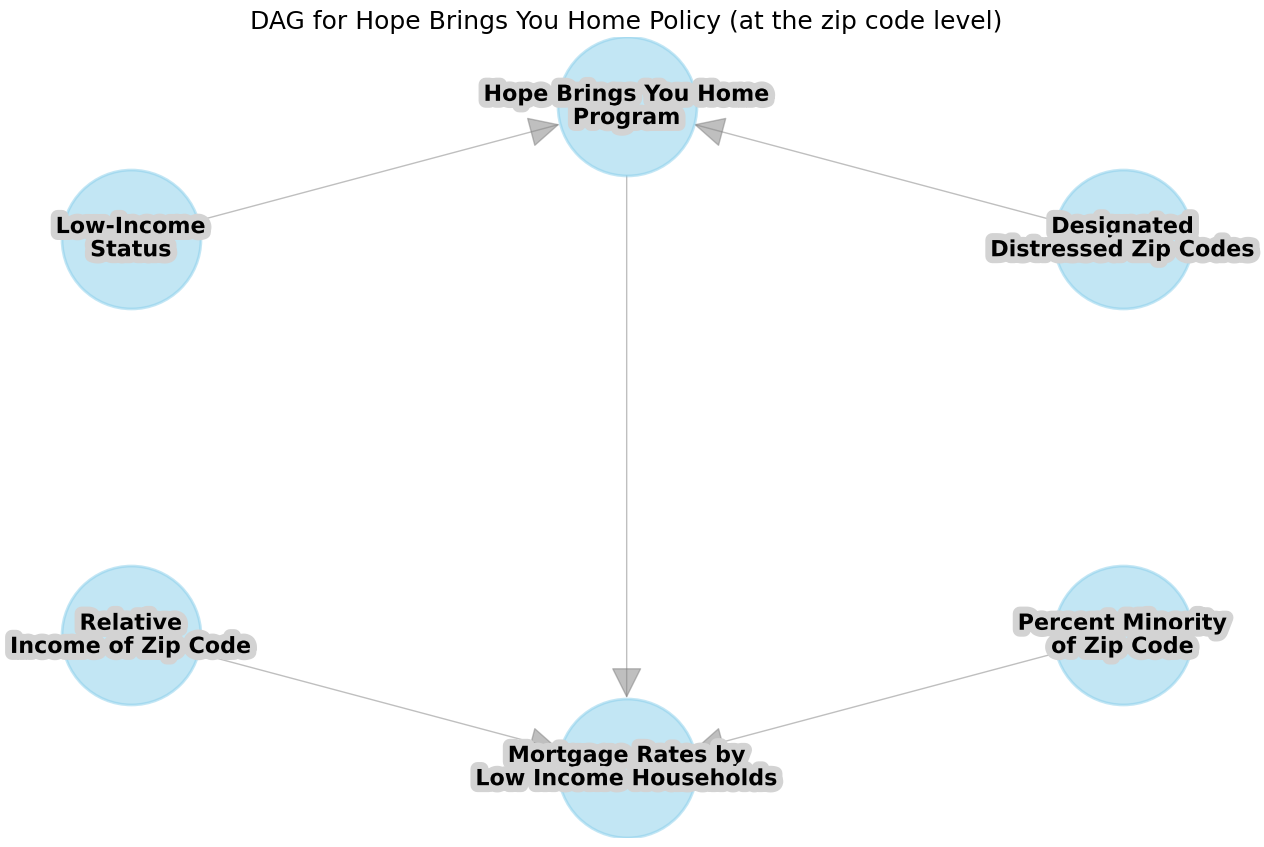

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import patheffects

# Create a directed graph
dag = nx.DiGraph()

# Add nodes representing variables and the policy
nodes = {
    "Program": "Hope Brings You Home\nProgram",
    "Rates": "Mortgage Rates by\nLow Income Households",
    "Income": "Low-Income\nStatus",
    "ZipCodes": "Designated\nDistressed Zip Codes",
    "RelIncome": "Relative\nIncome of Zip Code",
    "Minority": "Percent Minority\nof Zip Code"
}

dag.add_nodes_from(nodes.values())

# Add edges representing causal relationships
edges = [
    (nodes["Program"], nodes["Rates"]),
    (nodes["Income"], nodes["Program"]),
    (nodes["ZipCodes"], nodes["Program"]),
    (nodes["RelIncome"], nodes["Rates"]),
    (nodes["Minority"], nodes["Rates"])
]

dag.add_edges_from(edges)

# Manually specify the layout
pos = {
    nodes["Program"]: (0.5, 1),
    nodes["Rates"]: (0.5, 0),
    nodes["Income"]: (0.3, 0.8),
    nodes["ZipCodes"]: (0.7, 0.8),
    nodes["RelIncome"]: (0.3, 0.2),
    nodes["Minority"]: (0.7, 0.2)
}

# Draw the DAG with the specified positions
plt.figure(figsize=(12, 8))
nx.draw(dag, pos, with_labels=False, node_color='skyblue', node_size=10000, alpha=0.5, 
        edge_color='gray', linewidths=2, font_size=12, font_weight='bold', arrows=True, arrowsize = 50)

# Draw custom labels with wrapped text and outline effect
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=16, fontweight='bold', ha='center', va='center',
             path_effects=[patheffects.withStroke(linewidth=10, foreground='lightgray')])

# Display the DAG
plt.title("DAG for Hope Brings You Home Policy (at the zip code level)", fontsize = 18)
plt.show()


#### Matching

Here, a synthetic control is being created, following Alves (2022)'s matching strategy. The control is based on covariates from 2012 to 2017. To enhance algorithm efficiency, instead of starting with uniform weights, the process begins with the weights determined in the first iteration. This approach is based on the assumption that many of the treated tracts in Las Vegas share similar characteristics, such as being low-income and having a higher minority status, compared to a uniform distribution across a city. This adjustment is expected to expedite the optimization process. Due to computational constraints, only Fresno and Tucson are used in this analysis.

In [ ]:
import pandas as pd 
from scipy.optimize import fmin_slsqp
from toolz import partial
import numpy as np 
import matplotlib.pyplot as plt

collapsed_df = pd.read_csv(r'C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\20122019_collapsed_mortgage.csv')

#this was a crosswalk dataframe from zipcodes to census tracts found by merging IMPUS GIS data then saving the overlapping regions as a csv
#some regions that have parts in the zip code and parts outside of the zip code were considered 'treated' even though not everyone in this region may recieve this treatment
crosswalk = pd.read_csv(r"C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\filtered_zip_tract.csv")
crosswalk.columns = crosswalk.columns.str.lstrip('0') #changing codes from '06' -> '6'

#loss function we are minimizing
def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

#function to get the weights
def get_w(X, y, initial_weights=None):
    if initial_weights is None:
        initial_weights = [1/X.shape[1]] * X.shape[1]
    
    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(initial_weights),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)] * len(initial_weights),
                         disp=False)
    return weights


control_pool = collapsed_df[(collapsed_df['County - 2010 Census'] == 19) | (collapsed_df['County - 2010 Census'] == 50)].drop(columns=['US Postal State Code', 'County - 2010 Census']) 
treated = collapsed_df[collapsed_df['Census Tract - 2010 Census'].isin(crosswalk['TRACTCE'])]
treated = treated[treated['County - 2010 Census'] == 3].drop(columns=['US Postal State Code', 'County - 2010 Census']) #some overlap between county and codes so make sure its the correct filter
print("Length of treated:", len(treated))
print("Length of control_pool:", len(control_pool))


treated = treated.melt(id_vars=['Census Tract - 2010 Census'], var_name='variable', value_name='value')
treated = treated.pivot(index='variable', columns='Census Tract - 2010 Census', values='value')
control_pool = control_pool.melt(id_vars=['Census Tract - 2010 Census'], var_name='variable', value_name='value')
control_pool = control_pool.pivot(index='variable', columns='Census Tract - 2010 Census', values='value')
#control_pool=control_pool.iloc[:, :10] for if you want to test and have it work in finite time
synthetic_controls = {}

#dont want to train on what we want to predict after the policy occurs
rows_to_keep = ~treated.index.str.contains('2018|2019')
treated_dropped = treated[rows_to_keep]
control_dropped = control_pool[rows_to_keep]
synthetic_controls_df = pd.DataFrame()

first_iteration = True
stored_weights = None

#for n, column in enumerate(treated.columns):
for n, column in enumerate(treated_dropped.columns[:2]):
    print(n)
    y = treated_dropped[column].values  # Treated unit's values
    X = control_dropped.values          # Control units' values
    #slightly faster to start here rather than uniform
    if first_iteration:
        weights = get_w(X, y)
        stored_weights = weights
        first_iteration = False
    else:
        weights = get_w(X, y, initial_weights=stored_weights)

    synthetic_control = control_pool.dot(weights)
    # Store the synthetic control series in the dictionary more efficient than df
    synthetic_controls[f'syn_{column}'] = synthetic_control
synthetic_controls_df = pd.DataFrame(synthetic_controls)
treated = pd.concat([treated, synthetic_controls_df], axis=1)

#save as a treated csv to use later, again since this process takes so long to run
#commented out so I dont ruin my csv by accident
#treated.to_csv(r'C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\treated_dataframe.csv', index=True)

#### Cleaning the dataframe to be in a Diff-in-Diff format

In [3]:
# Read out treated df from above since it takes forever to run
import pandas as pd #since we didnt run the cleaning we need to import again
treated = pd.read_csv(r'C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\treated_dataframe.csv')
#this is getting rid of the Tract Income Ratio which is the last column and 2010 Census Tract - Percent Minority which is first
treated = treated.drop([0, len(treated)-1]) 
#get a list of all the treated tracts
tracts = treated.columns[:len(treated.columns)//2].tolist()
all_tracts_long_df = pd.DataFrame()

# Loop over each tract to transpose and melt the data into a format we can run the DiD on
for tract in tracts:
    col_df = treated[[tract, f'syn_{tract}']].transpose()
    
    # Rename the columns to years observed
    new_column_names = {i: year for i, year in enumerate(range(2012, 2012 + len(col_df.columns)), start=1)}
    col_df = col_df.rename(columns=new_column_names)
    long_df = col_df.reset_index().melt(id_vars='index', var_name='Year', value_name='Value')
    
    long_df = long_df.rename(columns={'index': 'Group'})
    long_df['Tract'] = tract  # keep track of the tract
    # Append to the all_tracts_long_df DataFrame
    all_tracts_long_df = pd.concat([all_tracts_long_df, long_df], ignore_index=True)

all_tracts_long_df['Year'] = all_tracts_long_df['Year'].astype(int)
# Create 'treated' and 'post' columns
all_tracts_long_df['treated'] = all_tracts_long_df['Group'].apply(lambda x: 1 if 'syn' not in x else 0)
all_tracts_long_df['post'] = all_tracts_long_df['Year'].apply(lambda x: 1 if x >= 2018 else 0)

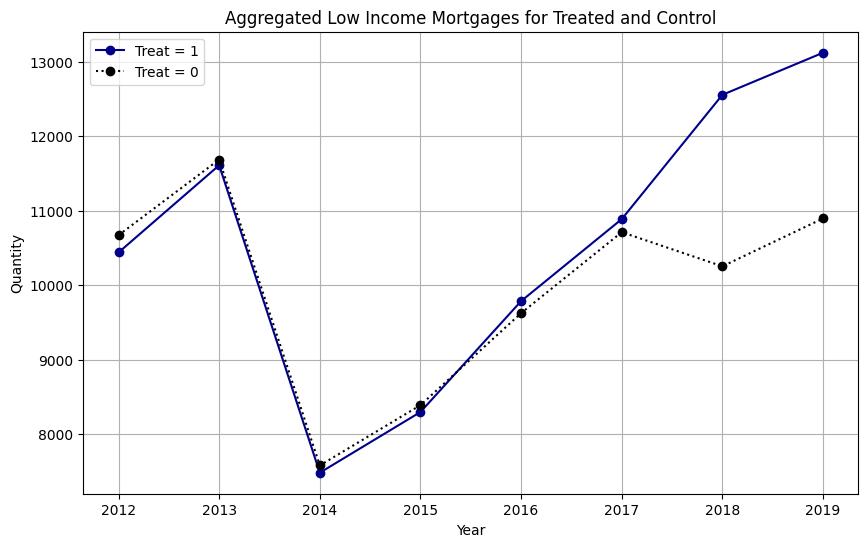

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
colors = ['darkblue', 'black']  # Specify the colors for each line
line = ['-',':']
for i, treat in enumerate([1, 0]):
    subset = all_tracts_long_df[all_tracts_long_df['treated'] == treat]
    plt.plot(subset['Year'].unique(), subset.groupby('Year')['Value'].sum(), marker='o', label=f'Treat = {treat}', linestyle =line[i],  color=colors[i])

plt.xlabel('Year')
plt.ylabel('Quantity')
plt.title('Aggregated Low Income Mortgages for Treated and Control')
plt.legend()
plt.grid(True)
plt.show()

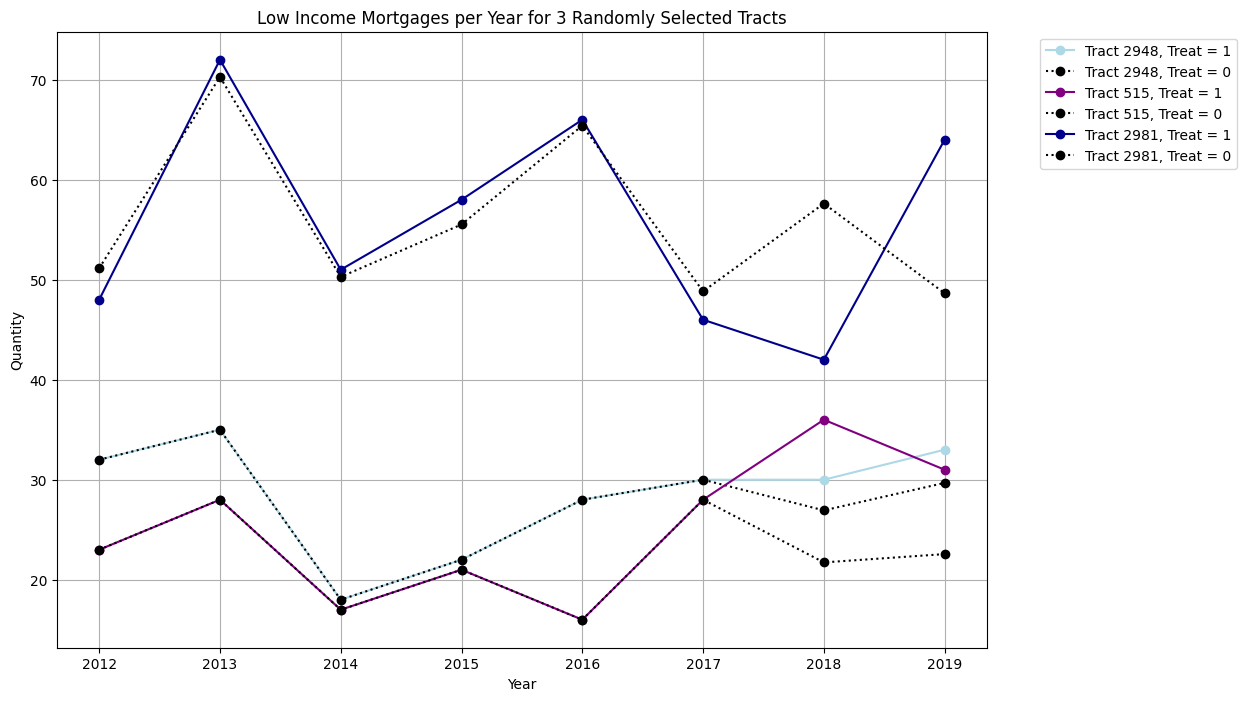

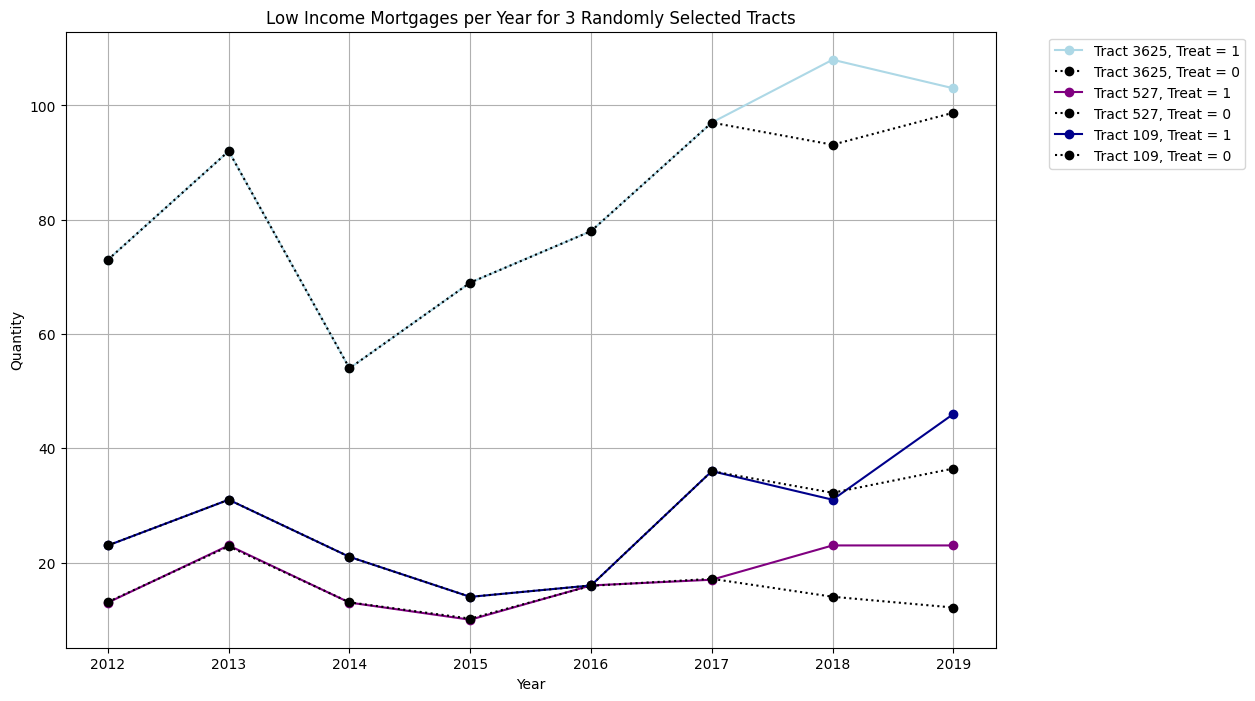

In [5]:
import random
random.seed(47)
# Generate random tracts
random_tracts_1 = random.sample(tracts, 3)

random.seed(42)
random_tracts_2 = random.sample(tracts, 3)
random_tracts = [random_tracts_1, random_tracts_2]
# Initialize plot
colors = ['lightblue', 'purple', 'darkblue']

# Plot for each tract
for n in [0,1]:
    plt.figure(figsize=(12, 8))

    for i, tract in enumerate(random_tracts[n]):
        # Filter data for each tract and treatment type
        tract_data_treat_1 = all_tracts_long_df[(all_tracts_long_df['Tract'] == tract) & (all_tracts_long_df['treated'] == 1)]
        tract_data_treat_0 = all_tracts_long_df[(all_tracts_long_df['Tract'] == tract) & (all_tracts_long_df['treated'] == 0)]

        # Sort by year to make line plot correct
        tract_data_treat_1 = tract_data_treat_1.sort_values('Year')
        tract_data_treat_0 = tract_data_treat_0.sort_values('Year')

        # Plot lines for treat = 1 in light blue
        plt.plot(tract_data_treat_1['Year'], tract_data_treat_1['Value'], color=colors[i],  marker='o', label=f'Tract {tract}, Treat = 1')
        
        # Plot lines for treat = 0 in dotted black
        plt.plot(tract_data_treat_0['Year'], tract_data_treat_0['Value'], color='black', linestyle=':', marker='o', label=f'Tract {tract}, Treat = 0')

    # Set plot features
    plt.xlabel('Year')
    plt.ylabel('Quantity')
    plt.title('Low Income Mortgages per Year for 3 Randomly Selected Tracts')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


## Diff and Diff 

Here I am doing inference on the matched groups. We are controling for the census tract as that is what we matched on and running many sub diff and diff's essentially. The treated:post interaction term at the bottom of my regression output shows us the overall impact this policy had on mortgage rates on low income indivisuals in Las Vegas relative to our synthetic controls we derived. 

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import io 

# Fit the DiD model with 'Tract' as a fixed effect
did_formula = 'Value ~ treated + post + treated:post + C(Tract)'
did_model = smf.ols(formula=did_formula, data=all_tracts_long_df).fit() 
#print(did_model.summary()) #summary is just a ton of fixed effects but here is the output on the interaction term
html_table = did_model.summary().tables[1].as_html()
summary_df = pd.read_html(io.StringIO(html_table), header=0, index_col=0)[0]
row = summary_df.loc['treated:post']

# look at the specific interaction term we want (you can also uncomment the did summary but it
# has so many fixed effects that its hard to read)
summary_df = pd.DataFrame(row).T
summary_df

,coef,std err,t,P>|t|,[0.025,0.975]
treated:post,9.7065,0.993,9.779,0.0,7.76,11.653


### Concluding Remark

Please see the pdf for all the additional caveats and interpretations of the results!